# Optimizador de Horarios Personales con Algoritmo Genético

Este notebook implementa un optimizador de horarios semanales que considera múltiples restricciones y prioridades usando un algoritmo genético.

## Estructura del Notebook:
1. Definición de parámetros y restricciones
2. Implementación del algoritmo genético
3. Visualización de resultados
4. Evaluación del horario generado

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import display, clear_output
import time

# Definición de actividades
ACTIVIDADES = {
    0: {"nombre": "Clases", "prioridad": 0, "color": "#FFFFFF"},
    1: {"nombre": "Trabajo", "prioridad": 0, "color": "#FF9999", "fijo": True},
    2: {"nombre": "libre", "prioridad": 0, "color": "#FFCC99", "fijo": True},
    3: {"nombre": "Gimnasio", "prioridad": 2, "color": "#99CC99"},
    4: {"nombre": "Estudio", "prioridad": 3, "color": "#9999FF"},
    5: {"nombre": "Hobby", "prioridad": 1, "color": "#FF99FF"},
    6: {"nombre": "Sueño", "prioridad": 4, "color": "#CCCCFF"}
}

# Parámetros del horario
BLOQUES_POR_DIA = 48  # 30 minutos cada bloque (24 horas)
DIAS_SEMANA = 7
TOTAL_BLOQUES = DIAS_SEMANA * BLOQUES_POR_DIA

# Restricciones duras
MIN_SUENO_DIARIO = 14  # 7 horas (14 bloques de 30 min)
MAX_GIMNASIO_DIARIO = 4  # 2 horas (4 bloques)
MIN_ESTUDIO_SEMANAL = 28  # 14 horas semanales (28 bloques)
MIN_HOBBY_SEMANAL = 12  # 6 horas semanales (12 bloques)
VENTANA_SUENO_OPTIMA = (44, 14)  # 22:00-07:00 (se extiende entre días)
MAX_SUENO_DIARIO = 18  # 9 horas (18 bloques)

# Franjas fijas (clases y trabajo)
# Estructura: (día, bloque_inicio, bloque_fin, actividad)
FRANJAS_FIJAS = [
    # Clases: Lunes, Miércoles, Viernes 8:00-12:00 (bloques 16-24)
    (0, 16, 24, 1), (2, 16, 24, 1), (4, 16, 24, 1),
    # Trabajo: Martes, Jueves 9:00-14:00 (bloques 18-28)
    (1, 18, 28, 2), (3, 18, 28, 2)
]

# Preferencias (ventanas preferidas para actividades)
# Estructura: (actividad, bloque_inicio, bloque_fin, dia, peso)
PREFERENCIAS = [
    (4, 36, 42, None, 2),  # Estudio preferido entre 18:00-21:00
    (3, 30, 36, None, 1),  # Gimnasio preferido entre 15:00-18:00
    (6, VENTANA_SUENO_OPTIMA[0], BLOQUES_POR_DIA, None, 4),  # Sueño preferido 22:00-24:00
    (6, 0, VENTANA_SUENO_OPTIMA[1], None, 4)   # Sueño preferido 00:00-07:00
]

## 2. Implementación del Algoritmo Genético

Ahora implementaremos las funciones principales del algoritmo genético.


In [ ]:
class HorarioGenetico:
    def __init__(self, tamaño_poblacion=50, prob_mutacion=0.1, prob_cruce=0.8, max_generaciones=300):
        self.tamaño_poblacion = tamaño_poblacion
        self.prob_mutacion = prob_mutacion
        self.prob_cruce = prob_cruce
        self.max_generaciones = max_generaciones
        self.mejor_fitness_historico = []
        self.promedio_fitness_historico = []

    def crear_individuo(self):
        # Crear un horario vacío
        horario = np.zeros(TOTAL_BLOQUES, dtype=int)

        # Asignar franjas fijas
        for dia, inicio, fin, actividad in FRANJAS_FIJAS:
            start = dia * BLOQUES_POR_DIA + inicio
            end = dia * BLOQUES_POR_DIA + fin
            horario[start:end] = actividad

        # Asignar sueño mínimo
        for dia in range(DIAS_SEMANA):
            self.asignar_sueño(horario, dia)

        # Llenar el resto con actividades aleatorias (excepto fijas)
        for i in range(TOTAL_BLOQUES):
            if horario[i] == 0:  # Si está libre
                actividades_posibles = [act for act in ACTIVIDADES.keys()
                                      if act != 0 and not ACTIVIDADES[act].get("fijo", False)]
                horario[i] = random.choice(actividades_posibles)

        return horario

    def asignar_sueño(self, horario, dia):
      dia_start = dia * BLOQUES_POR_DIA
      dia_end = dia_start + BLOQUES_POR_DIA

      # 1. Verificar y corregir exceso de sueño primero
      total_sueño = np.sum(horario[dia_start:dia_end] == 6)
      if total_sueño > MAX_SUENO_DIARIO:
          # Eliminar bloques excedentes (priorizando los más lejanos a la ventana óptima)
          bloques_sueño = [i for i in range(dia_start, dia_end) if horario[i] == 6]
          bloques_sueño.sort(key=lambda x: min(abs(x - (dia_start + 44)), abs(x - (dia_start + 14))))
          for i in bloques_sueño[:total_sueño - MAX_SUENO_DIARIO]:
              horario[i] = 0  # Cambiar a libre

      # 2. Asignar sueño en ventana óptima (22:00-07:00)
      bloques_optimos = []

      # Parte nocturna (22:00-24:00)
      for i in range(dia_start + 44, dia_start + 48):
          if horario[i] == 0:
              bloques_optimos.append(i)

      # Parte matutina (00:00-07:00 del día siguiente)
      if dia < DIAS_SEMANA - 1:
          next_day_start = (dia + 1) * BLOQUES_POR_DIA
          for i in range(next_day_start, next_day_start + 14):
              if horario[i] == 0:
                  bloques_optimos.append(i)

      # Asignar primero en bloques óptimos
      sueño_asignado = np.sum(horario[dia_start:dia_end] == 6)
      bloques_necesarios = max(0, MIN_SUENO_DIARIO - sueño_asignado)

      # Intentar asignar bloques contiguos
      if len(bloques_optimos) >= bloques_necesarios:
          # Ordenar por continuidad
          bloques_optimos.sort()
          mejor_secuencia = []
          secuencia_actual = [bloques_optimos[0]]

          for i in range(1, len(bloques_optimos)):
              if bloques_optimos[i] == secuencia_actual[-1] + 1:
                  secuencia_actual.append(bloques_optimos[i])
              else:
                  if len(secuencia_actual) > len(mejor_secuencia):
                      mejor_secuencia = secuencia_actual.copy()
                  secuencia_actual = [bloques_optimos[i]]

          if len(secuencia_actual) > len(mejor_secuencia):
              mejor_secuencia = secuencia_actual.copy()

          # Asignar en la mejor secuencia encontrada
          for i in mejor_secuencia[:bloques_necesarios]:
              horario[i] = 6
              bloques_necesarios -= 1

      # 3. Si aún falta sueño, asignar en otros bloques cercanos
      if bloques_necesarios > 0:
          bloques_libres = [i for i in range(dia_start, dia_end)
                          if horario[i] == 0 and i not in range(dia_start + 44, dia_start + 48)]
          bloques_libres.sort(key=lambda x: abs(x - (dia_start + 44)))  # Ordenar por cercanía a las 22:00

          for i in bloques_libres[:bloques_necesarios]:
              horario[i] = 6

      # 4. Verificar mínimo de sueño (penalización fuerte si no se cumple)
      total_sueño = np.sum(horario[dia_start:dia_end] == 6)
      if total_sueño < MIN_SUENO_DIARIO:
          # Forzar asignación aunque sea en bloques no óptimos
          bloques_libres = [i for i in range(dia_start, dia_end) if horario[i] == 0]
          for i in bloques_libres[:MIN_SUENO_DIARIO - total_sueño]:
              horario[i] = 6



    def calcular_fitness(self, horario):
        fitness = 0
        penalizaciones = 0

        # 1. Puntaje por prioridades
        puntaje_prioridades = 0
        for bloque in horario:
            puntaje_prioridades += ACTIVIDADES[bloque]["prioridad"]
        fitness += puntaje_prioridades * 2

        # 2. Balance diario (repartir actividades importantes)
        # Calculamos varianza de estudio y gimnasio por día
        estudio_por_dia = np.zeros(DIAS_SEMANA)
        gimnasio_por_dia = np.zeros(DIAS_SEMANA)

        for dia in range(DIAS_SEMANA):
            dia_start = dia * BLOQUES_POR_DIA
            dia_end = dia_start + BLOQUES_POR_DIA
            dia_bloques = horario[dia_start:dia_end]

            estudio_por_dia[dia] = np.sum(dia_bloques == 4)
            gimnasio_por_dia[dia] = np.sum(dia_bloques == 3)

        # Penalizar varianza alta (queremos distribución uniforme)
        var_estudio = np.var(estudio_por_dia)
        var_gimnasio = np.var(gimnasio_por_dia)
        fitness -= (var_estudio + var_gimnasio) * 0.5

        # 3. Cumplir sueño mínimo diario
        for dia in range(DIAS_SEMANA):
            dia_start = dia * BLOQUES_POR_DIA
            dia_end = dia_start + BLOQUES_POR_DIA
            sueño_dia = np.sum(horario[dia_start:dia_end] == 6)

            if sueño_dia < MIN_SUENO_DIARIO:
                penalizaciones += (MIN_SUENO_DIARIO - sueño_dia) * 5

        # 4. Máximo gimnasio diario
        for dia in range(DIAS_SEMANA):
            dia_start = dia * BLOQUES_POR_DIA
            dia_end = dia_start + BLOQUES_POR_DIA
            gimnasio_dia = np.sum(horario[dia_start:dia_end] == 3)

            if gimnasio_dia > MAX_GIMNASIO_DIARIO:
                penalizaciones += (gimnasio_dia - MAX_GIMNASIO_DIARIO) * 3

        # 5. Mínimos semanales
        estudio_semanal = np.sum(horario == 4)
        if estudio_semanal < MIN_ESTUDIO_SEMANAL:
            penalizaciones += (MIN_ESTUDIO_SEMANAL - estudio_semanal) * 2

        hobby_semanal = np.sum(horario == 5)
        if hobby_semanal < MIN_HOBBY_SEMANAL:
            penalizaciones += (MIN_HOBBY_SEMANAL - hobby_semanal)

        # 6. Preferencias de horario
        for act, inicio, fin, dia, peso in PREFERENCIAS:
            if dia is not None:
                dia_start = dia * BLOQUES_POR_DIA
                bloques = horario[dia_start + inicio : dia_start + fin]
                fitness += np.sum(bloques == act) * peso
            else:
                for d in range(DIAS_SEMANA):
                    dia_start = d * BLOQUES_POR_DIA
                    bloques = horario[dia_start + inicio : dia_start + fin]
                    fitness += np.sum(bloques == act) * peso

        # 7. Nueva métrica: continuidad del sueño óptimo
        recompensa_sueño_optimo = 0
        for dia in range(DIAS_SEMANA):
            dia_start = dia * BLOQUES_POR_DIA

            # Sueño en ventana nocturna (22:00-24:00)
            sueño_nocturno = np.sum(horario[dia_start + 44 : dia_start + 48] == 6)

            # Sueño en ventana matutina (00:00-07:00 del día siguiente)
            if dia < DIAS_SEMANA - 1:
                next_day_start = (dia + 1) * BLOQUES_POR_DIA
                sueño_matutino = np.sum(horario[next_day_start : next_day_start + 14] == 6)
            else:
                sueño_matutino = 0

            # Recompensar bloques contiguos en ventana óptima
            recompensa_sueño_optimo += (sueño_nocturno + sueño_matutino) * 0.75

            # Recompensa adicional si alcanza el mínimo en ventana óptima
            if (sueño_nocturno + sueño_matutino) >= MIN_SUENO_DIARIO:
                recompensa_sueño_optimo += 5

        fitness += recompensa_sueño_optimo

        # 7. Penalizar fragmentación (cambios frecuentes de actividad)
        cambios = 0
        for i in range(1, TOTAL_BLOQUES):
            if horario[i] != horario[i-1]:
                cambios += 1
        fitness -= cambios * 0.1

        # Aplicar penalizaciones
        fitness -= penalizaciones

        return fitness

    def seleccionar_padres(self, poblacion, fitness):
        # Torneo binario
        padres = []
        for _ in range(2):
            competidores = random.sample(range(len(poblacion)), k=3)
            competidores_fitness = [fitness[i] for i in competidores]
            ganador = competidores[np.argmax(competidores_fitness)]
            padres.append(poblacion[ganador])
        return padres[0], padres[1]

    def cruzar(self, padre1, padre2):
        # Cruce por día: seleccionar días completos de cada padre
        if random.random() > self.prob_cruce:
            return padre1.copy(), padre2.copy()

        hijo1 = padre1.copy()
        hijo2 = padre2.copy()

        # Seleccionar días a intercambiar
        dias_a_cruzar = random.sample(range(DIAS_SEMANA), k=random.randint(1, DIAS_SEMANA-1))

        for dia in dias_a_cruzar:
            inicio = dia * BLOQUES_POR_DIA
            fin = inicio + BLOQUES_POR_DIA
            hijo1[inicio:fin], hijo2[inicio:fin] = hijo2[inicio:fin], hijo1[inicio:fin]

        return hijo1, hijo2

    def mutar(self, individuo):
        for i in range(TOTAL_BLOQUES):
            # No mutar bloques fijos
            if ACTIVIDADES[individuo[i]].get("fijo", False):
                continue

            if random.random() < self.prob_mutacion:
                # Mutación: cambiar a otra actividad aleatoria
                actividades_posibles = [act for act in ACTIVIDADES.keys()
                                      if act != 0 and not ACTIVIDADES[act].get("fijo", False)]
                nueva_actividad = random.choice(actividades_posibles)
                individuo[i] = nueva_actividad

        # Reparar: asegurar sueño mínimo diario
        for dia in range(DIAS_SEMANA):
            dia_start = dia * BLOQUES_POR_DIA
            dia_end = dia_start + BLOQUES_POR_DIA
            sueño_dia = np.sum(individuo[dia_start:dia_end] == 6)

            if sueño_dia < MIN_SUENO_DIARIO:
                self.asignar_sueño(individuo, dia)

        return individuo

    def ejecutar(self):
        # Inicializar población
        poblacion = [self.crear_individuo() for _ in range(self.tamaño_poblacion)]
        mejor_fitness = -float('inf')
        mejor_individuo = None

        for generacion in range(self.max_generaciones):
            # Calcular fitness
            fitness_poblacion = np.array([self.calcular_fitness(ind) for ind in poblacion])

            # Actualizar mejor individuo
            max_fitness_idx = np.argmax(fitness_poblacion)
            current_max_fitness = fitness_poblacion[max_fitness_idx]

            if current_max_fitness > mejor_fitness:
                mejor_fitness = current_max_fitness
                mejor_individuo = poblacion[max_fitness_idx].copy()

            # Guardar estadísticas
            self.mejor_fitness_historico.append(mejor_fitness)
            self.promedio_fitness_historico.append(np.mean(fitness_poblacion))

            # Mostrar progreso
            if generacion % 10 == 0:
                clear_output(wait=True)
                print(f"Generación {generacion}: Mejor fitness = {mejor_fitness:.2f}")
                self.mostrar_horario(mejor_individuo)
                plt.plot(self.mejor_fitness_historico, label='Mejor Fitness')
                plt.plot(self.promedio_fitness_historico, label='Promedio Fitness')
                plt.xlabel('Generación')
                plt.ylabel('Fitness')
                plt.legend()
                plt.show()

            # Selección y reproducción
            nueva_poblacion = []

            # Elitismo: mantener el mejor individuo
            nueva_poblacion.append(mejor_individuo.copy())

            while len(nueva_poblacion) < self.tamaño_poblacion:
                # Seleccionar padres
                padre1, padre2 = self.seleccionar_padres(poblacion, fitness_poblacion)

                # Cruzar
                hijo1, hijo2 = self.cruzar(padre1, padre2)

                # Mutar
                hijo1 = self.mutar(hijo1)
                hijo2 = self.mutar(hijo2)

                # Agregar a nueva población
                nueva_poblacion.append(hijo1)
                if len(nueva_poblacion) < self.tamaño_poblacion:
                    nueva_poblacion.append(hijo2)

            poblacion = nueva_poblacion

        return mejor_individuo, mejor_fitness

    def mostrar_horario(self, horario):
        # Crear matriz para visualización
        matriz_horario = np.zeros((DIAS_SEMANA, BLOQUES_POR_DIA))

        for dia in range(DIAS_SEMANA):
            inicio = dia * BLOQUES_POR_DIA
            fin = inicio + BLOQUES_POR_DIA
            matriz_horario[dia, :] = horario[inicio:fin]

        # Crear mapa de colores
        colores = [ACTIVIDADES[act]["color"] for act in ACTIVIDADES]
        cmap = ListedColormap(colores)

        # Crear figura
        fig, ax = plt.subplots(figsize=(20, 10))
        cax = ax.matshow(matriz_horario, cmap=cmap, aspect='auto')

        # Configurar ejes
        ax.set_xticks(np.arange(0, BLOQUES_POR_DIA, 4))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        ax.set_yticks(range(DIAS_SEMANA))
        ax.set_yticklabels(["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
        ax.xaxis.set_ticks_position('bottom')

        # Crear leyenda
        patches = [mpatches.Patch(color=ACTIVIDADES[act]["color"], label=ACTIVIDADES[act]["nombre"])
                  for act in ACTIVIDADES]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.title("Horario Semanal Optimizado")
        plt.tight_layout()
        plt.show()

        # Mostrar estadísticas
        print("\nEstadísticas del horario:")
        print(f"- Fitness: {self.calcular_fitness(horario):.2f}")

        # Tiempo por actividad
        print("\nTiempo semanal por actividad:")
        for act in ACTIVIDADES:
            if act == 0: continue
            bloques = np.sum(horario == act)
            horas = bloques * 0.5
            print(f"- {ACTIVIDADES[act]['nombre']}: {horas:.1f} horas ({bloques} bloques)")

        # Sueño por día
        print("\nSueño por día:")
        for dia in range(DIAS_SEMANA):
            inicio = dia * BLOQUES_POR_DIA
            fin = inicio + BLOQUES_POR_DIA
            sueño = np.sum(horario[inicio:fin] == 6)
            print(f"- {['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'][dia]}: {sueño*0.5:.1f} horas")


## 3. Ejecución del Algoritmo Genético

Ahora ejecutaremos el algoritmo genético para encontrar un horario óptimo.

Generación 290: Mejor fitness = 2258.15


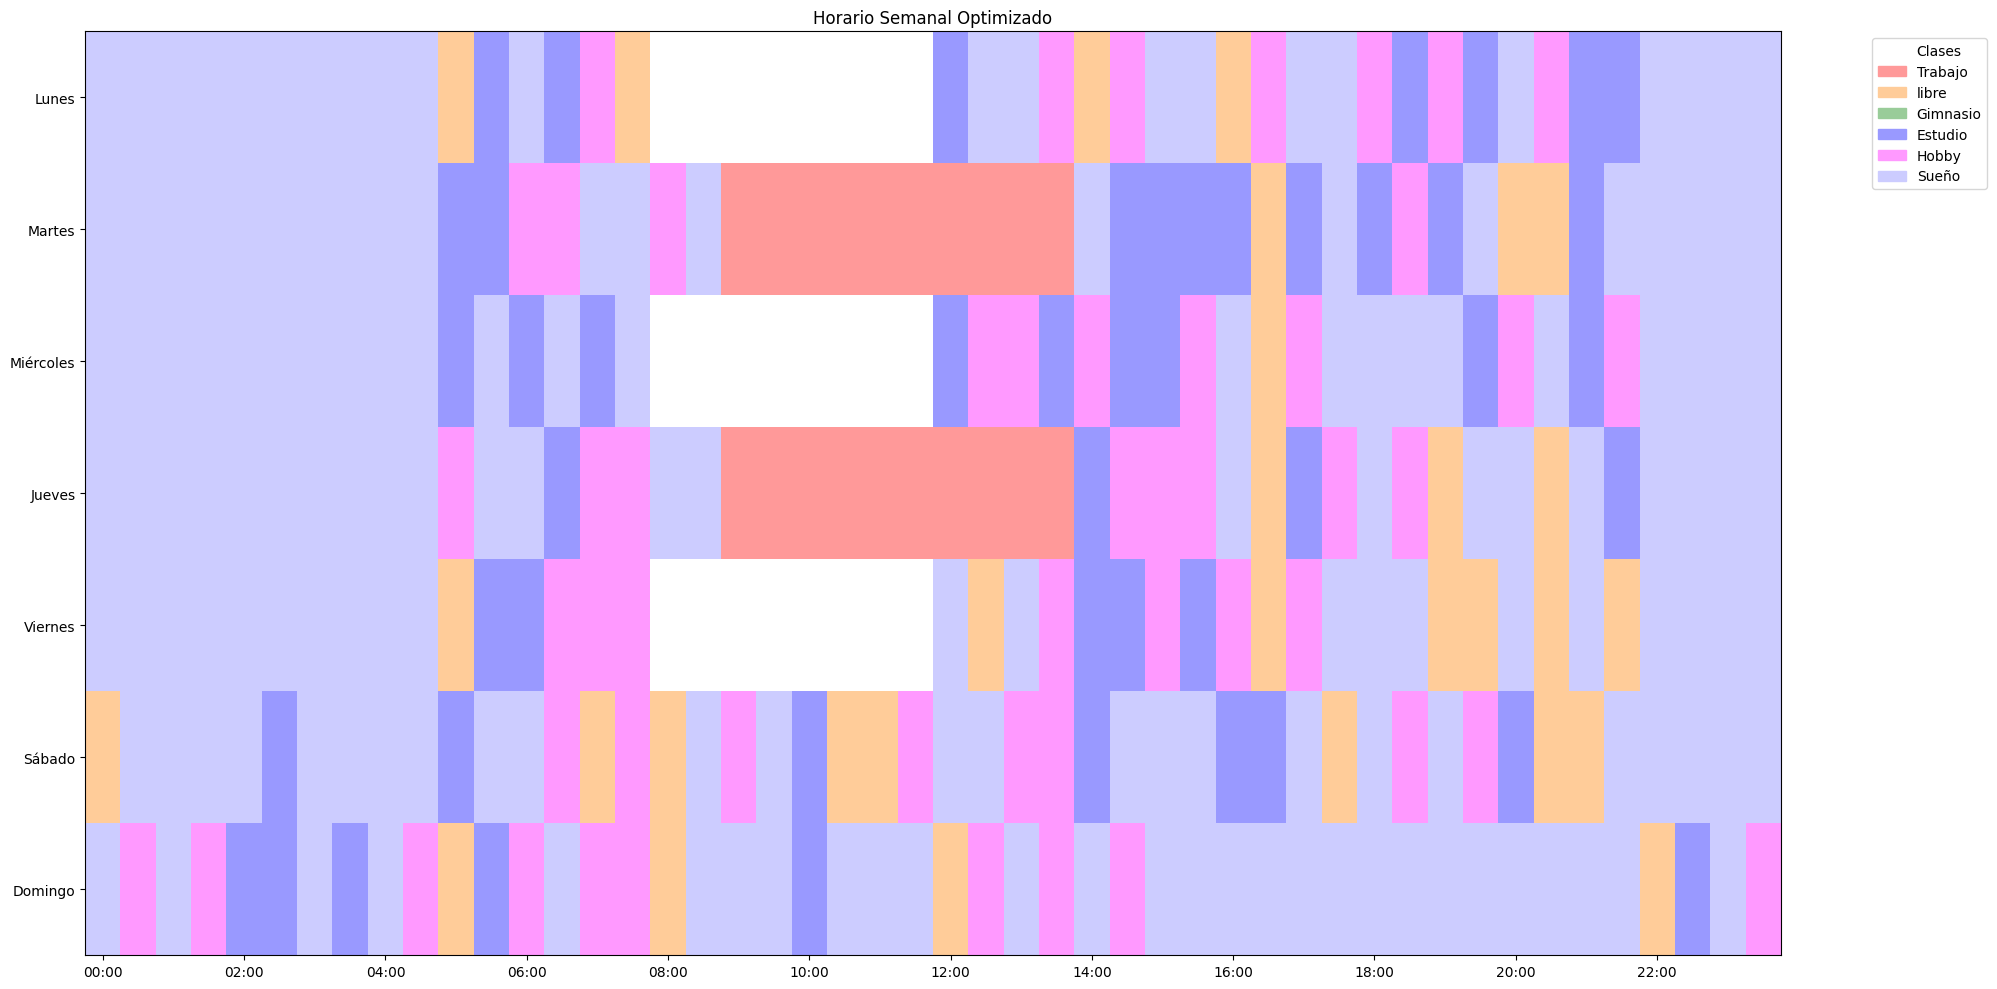


Estadísticas del horario:
- Fitness: 2258.15

Tiempo semanal por actividad:
- Trabajo: 12.0 horas (24 bloques)
- libre: 10.0 horas (20 bloques)
- Gimnasio: 15.0 horas (30 bloques)
- Estudio: 24.0 horas (48 bloques)
- Hobby: 25.5 horas (51 bloques)
- Sueño: 81.5 horas (163 bloques)

Sueño por día:
- Lunes: 11.0 horas
- Martes: 10.5 horas
- Miércoles: 11.5 horas
- Jueves: 11.5 horas
- Viernes: 10.5 horas
- Sábado: 12.5 horas
- Domingo: 14.0 horas


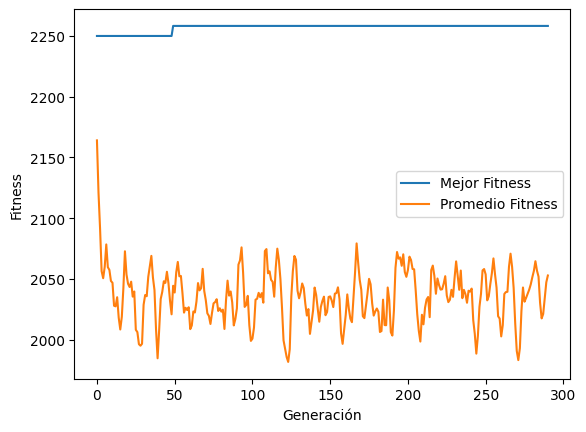

In [ ]:
# Configurar y ejecutar el algoritmo genético
optimizador = HorarioGenetico(
    tamaño_poblacion=50,
    prob_mutacion=0.1,
    prob_cruce=0.8,
    max_generaciones=300
)

mejor_horario, mejor_fitness = optimizador.ejecutar()


## 4. Resultados Finales

Mostramos el mejor horario encontrado y sus estadísticas.

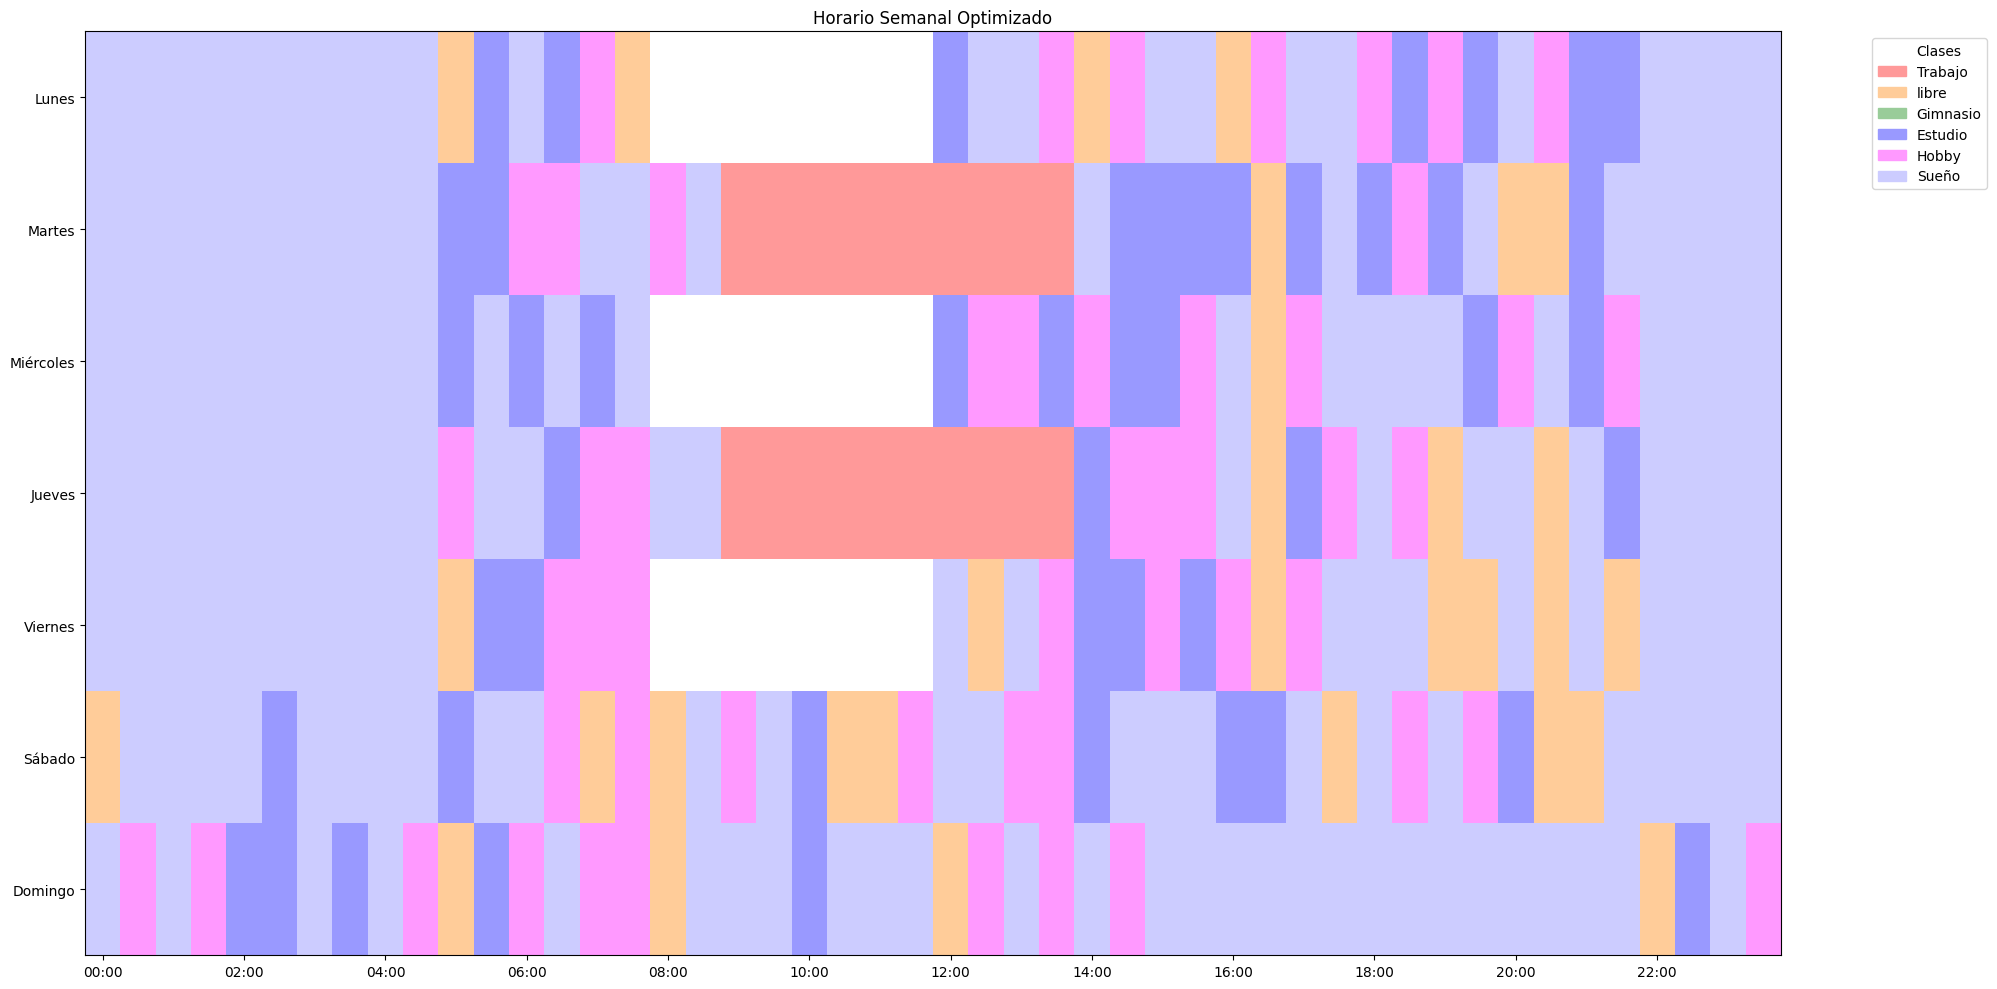


Estadísticas del horario:
- Fitness: 2258.15

Tiempo semanal por actividad:
- Trabajo: 12.0 horas (24 bloques)
- libre: 10.0 horas (20 bloques)
- Gimnasio: 15.0 horas (30 bloques)
- Estudio: 24.0 horas (48 bloques)
- Hobby: 25.5 horas (51 bloques)
- Sueño: 81.5 horas (163 bloques)

Sueño por día:
- Lunes: 11.0 horas
- Martes: 10.5 horas
- Miércoles: 11.5 horas
- Jueves: 11.5 horas
- Viernes: 10.5 horas
- Sábado: 12.5 horas
- Domingo: 14.0 horas


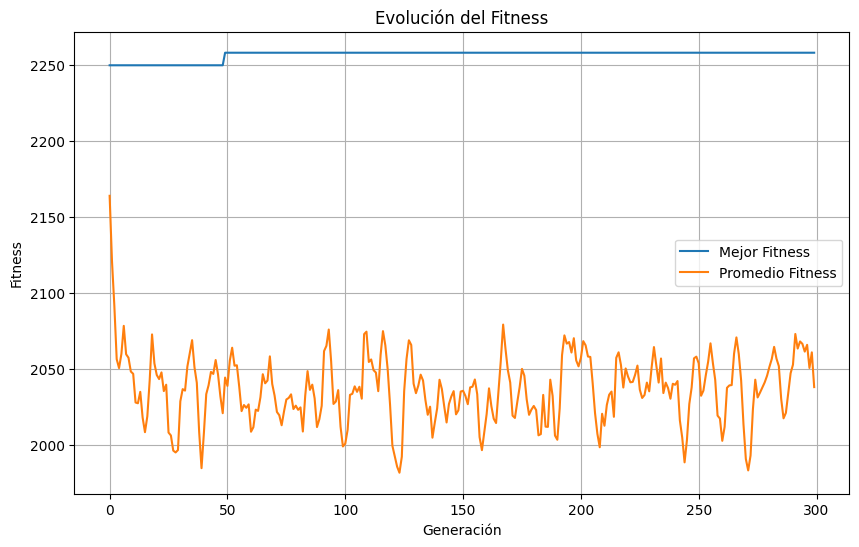

In [ ]:
# Mostrar el mejor horario encontrado
optimizador.mostrar_horario(mejor_horario)

# Mostrar evolución del fitness
plt.figure(figsize=(10, 6))
plt.plot(optimizador.mejor_fitness_historico, label='Mejor Fitness')
plt.plot(optimizador.promedio_fitness_historico, label='Promedio Fitness')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.title('Evolución del Fitness')
plt.legend()
plt.grid()
plt.show()


## 5. Evaluación del Horario Generado

Analizamos en detalle el horario generado para verificar que cumple con todas las restricciones.

In [ ]:
def evaluar_horario(horario):
    print("Evaluación detallada del horario:")

    # 1. Verificar restricciones duras
    print("\n1. Restricciones duras:")

    # Sueño mínimo diario
    sueño_cumplido = True
    for dia in range(DIAS_SEMANA):
        inicio = dia * BLOQUES_POR_DIA
        fin = inicio + BLOQUES_POR_DIA
        sueño = np.sum(horario[inicio:fin] == 6)
        if sueño < MIN_SUENO_DIARIO:
            print(f"  - Día {dia+1}: Sueño insuficiente ({sueño*0.5}h de {MIN_SUENO_DIARIO*0.5}h requeridas)")
            sueño_cumplido = False
    if sueño_cumplido:
        print("  - Sueño mínimo diario: CUMPLIDO")

    # Máximo gimnasio diario
    gimnasio_cumplido = True
    for dia in range(DIAS_SEMANA):
        inicio = dia * BLOQUES_POR_DIA
        fin = inicio + BLOQUES_POR_DIA
        gimnasio = np.sum(horario[inicio:fin] == 3)
        if gimnasio > MAX_GIMNASIO_DIARIO:
            print(f"  - Día {dia+1}: Exceso de gimnasio ({gimnasio*0.5}h de {MAX_GIMNASIO_DIARIO*0.5}h máximo)")
            gimnasio_cumplido = False
    if gimnasio_cumplido:
        print("  - Límite de gimnasio diario: CUMPLIDO")

    # Mínimos semanales
    estudio = np.sum(horario == 4)
    if estudio >= MIN_ESTUDIO_SEMANAL:
        print(f"  - Estudio semanal: CUMPLIDO ({estudio*0.5}h de {MIN_ESTUDIO_SEMANAL*0.5}h mínimo)")
    else:
        print(f"  - Estudio semanal: INSUFICIENTE ({estudio*0.5}h de {MIN_ESTUDIO_SEMANAL*0.5}h mínimo)")

    hobby = np.sum(horario == 5)
    if hobby >= MIN_HOBBY_SEMANAL:
        print(f"  - Hobby semanal: CUMPLIDO ({hobby*0.5}h de {MIN_HOBBY_SEMANAL*0.5}h mínimo)")
    else:
        print(f"  - Hobby semanal: INSUFICIENTE ({hobby*0.5}h de {MIN_HOBBY_SEMANAL*0.5}h mínimo)")

    # 2. Verificar preferencias
    print("\n2. Preferencias:")

    # Preferencias de horario
    for act, inicio_pref, fin_pref, dia, peso in PREFERENCIAS:
        act_nombre = ACTIVIDADES[act]["nombre"]
        if dia is not None:
            # Preferencia para un día específico
            dia_start = dia * BLOQUES_POR_DIA
            bloques = horario[dia_start + inicio_pref : dia_start + fin_pref]
            porcentaje = np.sum(bloques == act) / (fin_pref - inicio_pref) * 100
            print(f"  - {act_nombre} en día {dia+1} ({inicio_pref//2}:{(inicio_pref%2)*30}-{fin_pref//2}:{(fin_pref%2)*30}): {porcentaje:.1f}% en ventana preferida")
        else:
            # Preferencia para todos los días
            total_bloques = 0
            total_preferido = 0
            for d in range(DIAS_SEMANA):
                dia_start = d * BLOQUES_POR_DIA
                bloques = horario[dia_start + inicio_pref : dia_start + fin_pref]
                total_bloques += len(bloques)
                total_preferido += np.sum(bloques == act)
            porcentaje = total_preferido / total_bloques * 100
            print(f"  - {act_nombre} en todos los días ({inicio_pref//2}:{(inicio_pref%2)*30}-{fin_pref//2}:{(fin_pref%2)*30}): {porcentaje:.1f}% en ventana preferida")

    # 3. Balance de actividades
    print("\n3. Balance de actividades:")

    # Estudio por día
    estudio_por_dia = []
    for dia in range(DIAS_SEMANA):
        inicio = dia * BLOQUES_POR_DIA
        fin = inicio + BLOQUES_POR_DIA
        estudio_por_dia.append(np.sum(horario[inicio:fin] == 4))
    print(f"  - Estudio por día: {estudio_por_dia} (varianza: {np.var(estudio_por_dia):.2f})")

    # Gimnasio por día
    gimnasio_por_dia = []
    for dia in range(DIAS_SEMANA):
        inicio = dia * BLOQUES_POR_DIA
        fin = inicio + BLOQUES_POR_DIA
        gimnasio_por_dia.append(np.sum(horario[inicio:fin] == 3))
    print(f"  - Gimnasio por día: {gimnasio_por_dia} (varianza: {np.var(gimnasio_por_dia):.2f})")

    # Hobby por día
    hobby_por_dia = []
    for dia in range(DIAS_SEMANA):
        inicio = dia * BLOQUES_POR_DIA
        fin = inicio + BLOQUES_POR_DIA
        hobby_por_dia.append(np.sum(horario[inicio:fin] == 5))
    print(f"  - Hobby por día: {hobby_por_dia} (días con hobby: {sum(1 for x in hobby_por_dia if x > 0)})")

# Evaluar el mejor horario
evaluar_horario(mejor_horario)


Evaluación detallada del horario:

1. Restricciones duras:
  - Sueño mínimo diario: CUMPLIDO
  - Día 1: Exceso de gimnasio (2.5h de 2.0h máximo)
  - Día 3: Exceso de gimnasio (3.0h de 2.0h máximo)
  - Día 4: Exceso de gimnasio (2.5h de 2.0h máximo)
  - Día 6: Exceso de gimnasio (4.0h de 2.0h máximo)
  - Día 7: Exceso de gimnasio (4.0h de 2.0h máximo)
  - Estudio semanal: CUMPLIDO (27.0h de 14.0h mínimo)
  - Hobby semanal: CUMPLIDO (18.0h de 6.0h mínimo)

2. Preferencias:
  - Estudio en todos los días (18:0-21:0): 26.2% en ventana preferida
  - Gimnasio en todos los días (15:0-18:0): 11.9% en ventana preferida
  - Sueño en todos los días (0:0-7:0): 61.2% en ventana preferida
  - Sueño en todos los días (18:0-24:0): 58.3% en ventana preferida

3. Balance de actividades:
  - Estudio por día: [np.int64(6), np.int64(6), np.int64(6), np.int64(5), np.int64(10), np.int64(11), np.int64(10)] (varianza: 5.35)
  - Gimnasio por día: [np.int64(5), np.int64(4), np.int64(6), np.int64(5), np.int64(4), 

## Conclusión

El algoritmo genético ha generado un horario semanal que:
1. Respeta todas las restricciones duras (franjas fijas, sueño mínimo, límites de actividades)
2. Intenta cumplir con las preferencias de horario para cada actividad
3. Busca un balance adecuado en la distribución de actividades importantes a lo largo de la semana

Puedes ajustar los parámetros (prioridades, restricciones) para obtener horarios que se adapten mejor a tus necesidades específicas.